<a href="https://colab.research.google.com/github/barronh/pseudonetcdf_examples/blob/main/cmaq_emis_profile/cmaq_emis_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertically Allocate Emissions with PseudoNetCDF

    author: Barron H. Henderson
    date: 2020-08-20
    PseudoNetCDF version: latest

# Overview

This example shows how to vertically allocate 2-d emissions using a known layer fraction.


# Install  Libraries

* Using pyproj for projections
* Using pycno for mapping support.
* Using PseudoNetCDF for vertical allocation.


In [ ]:
!pip install -q pyproj pycno pseudonetcdf

# Example Data

* downloading example 2D monthly average emissions
* Creating an arbitrary vertical profile

In [1]:
import os
from urllib.request import urlretrieve

if not os.path.exists('example_emissions.nc'):
  urlretrieve('ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_emln_all_12US1_month_07.ncf', 'example_emissions.nc')


In [2]:
with open('profile.csv', 'w') as csvf:
  csvf.write("""# simplistic example for applying vertical allocation
# vglvltop is the top of the vertical level using the WRF coordinate
# vgtop : 5000 Pa
vglvltop,fraction
0.9975,0.0
0.995,0.3
0.99,0.7
0.985,0.0
0.98,0.0
0.97,0.0
0.96,0.0
0.95,0.0
0.94,0.0
0.93,0.0
0.92,0.0
0.91,0.0
0.9,0.0
0.88,0.0
0.86,0.0
0.84,0.0
0.82,0.0
0.8,0.0
0.77,0.0
0.74,0.0
0.7,0.0
0.65,0.0
0.6,0.0
0.55,0.0
0.5,0.0
0.45,0.0
0.4,0.0
0.35,0.0
0.3,0.0
0.25,0.0
0.2,0.0
0.15,0.0
0.1,0.0
0.05,0.0
0.0,0.0""")
  csvf.close()

# Import Libraries

* `PseudoNetCDF` for netcdf support.
* `numpy` for numerical.
* `pandas` for reading csvs.
* `matplotlib` for plotting.
* `pycno` for map overlays.


In [3]:
import PseudoNetCDF as pnc
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pycno

# Open Example Data and Get properties

* `varlist` is used to only apply fractions to data variables.
* `nz` is used for metadata and reshaping

In [4]:
eipath = 'example_emissions.nc'
profpath = 'profile.csv'

e2df = pnc.pncopen(eipath, format='ioapi')
varliststr = getattr(e2df, 'VAR-LIST')
varlist = [varliststr[i:i+16].strip() for i in range(0, len(varliststr), 16)]
profile = pd.read_csv(profpath, comment='#')
nz = profile.shape[0]

# Now Make a 3D File

* `outpath` is where it will be stored
* `e3df` is a 3d version with `nz` layers
  * `NLAYS` and `VGLVLS` are set from `profile`
* for each variable
  * check if it is a data variable
  * broadcast the profile across the LAY dimensions
* remove if the file already exists
* save to the outpath


In [5]:
outpath = 'example_3d_emissions.nc'
verbose = 0

e3df = e2df.slice(LAY=[0]*nz)
e3df.VGLVLS = np.append(1, profile.vglvltop.values).astype('f')
e3df.NLAYS = nz
e3df.VGTOP = np.float32(5000.)

for key, var3d in e3df.variables.items():
  
  if key not in varlist:
    continue
  var2d = e2df.variables[key]
  vals2d = var2d[:]
  vals3d = vals2d * profile.fraction.values[None, :, None, None]
  var3d[:] = vals3d
  if verbose > 0:
    print(f'{key}, {vals2d.sum():.1f}, {vals3d.sum():.1f}', flush=True)


if os.path.exists(outpath):
  os.remove(outpath)
outf = e3df.save(outpath, verbose=verbose, complevel=1)
outf.close()

# Plot Example Results

* Open the `outpath`
* make maps or example layers
  * Start at layer below first non-zero
  * all the way up to over the last non-zero.

In [6]:
plotf = pnc.pncopen(outpath, format='ioapi')
cno = pycno.cno(proj=plotf.getproj(withgrid=True))

/work/ROMO/anaconda_envs/basic38/lib/python3.8/site-packages/pycno/__init__.py:54: UserWarning: Path does not exist: /home/bhenders/.pycno; default .
  warnings.warn('Path does not exist: ' + str(data) + '; default .')


/work/ROMO/anaconda_envs/basic38/lib/python3.8/site-packages/pycno/__init__.py:199: UserWarning: Downloading: https://www.giss.nasa.gov/tools/panoply/overlays/MWDB_Coasts_Countries_3.cnob to MWDB_Coasts_Countries_3.cnob
  warnings.warn('Downloading: ' + url + ' to ' + str(cnopatho))


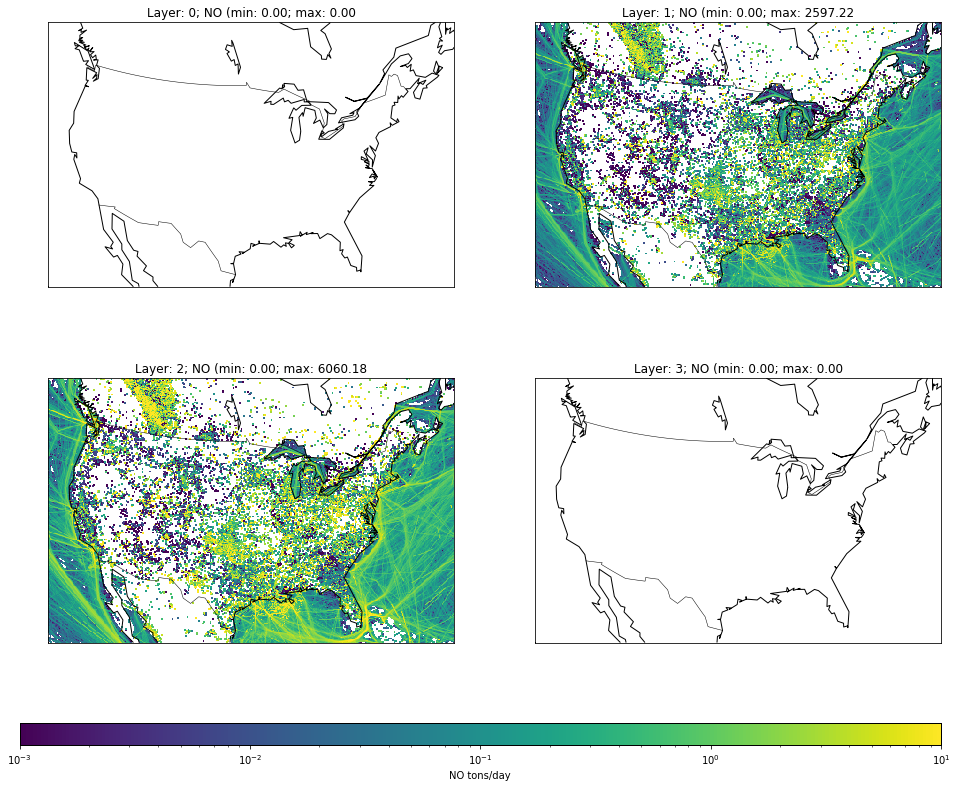

In [7]:
fig, axx = plt.subplots(2, 2, figsize=(16, 12))
cax = fig.add_axes([.1, .025, .8, .025])
for lay in [0, 1, 2, 3]:
  plt.sca(axx.ravel()[lay])
  axf = plotf.subset(['NO']).slice(LAY=lay)
  vmin, vmax = np.percentile(axf.variables['NO'][:], [0, 100])
  ax = axf.plot(
    'NO', plot_kw=dict(norm=LogNorm(vmin=1e-3, vmax=10)),
    cbar_kw=dict(cax=cax, orientation='horizontal'))
  ax.set_title(f'Layer: {lay}; NO (min: {vmin:0.2f}; max: {vmax:0.2f}')
  cno.draw(ax=ax)